In [1]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("Required Libraries Imported!")

Required Libraries Imported!


## Data Extraction

Using library Beautiful soup to extract data from wikipedia page link as follows: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Now converting the extracted postal codes to a dataframe

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url).content
soup = BeautifulSoup(result, 'html.parser')

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

cols = ['PostalCode', 'Borough', 'Neighborhood']
df=pd.DataFrame(table_contents, columns=cols)
print(df.shape)

(103, 3)


## Data Cleaning

In [3]:
df = df.groupby('PostalCode').agg(
    {
        'Borough':'first', 
        'Neighborhood': ', '.join,}
    ).reset_index()
df.shape

(103, 3)

In [4]:
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [5]:
df.describe()

,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,15,103
top,M9N,North York,"St. James Town, Cabbagetown"
freq,1,24,1


In [6]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.PostalCode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [7]:
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
def neighborhood_concat(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['PostalCode', 'Borough'])
df_2 = grp.apply(neighborhood_concat).reset_index(name='Neighborhood')

In [9]:
df_2.describe()

,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,15,103
top,M9N,North York,"St. James Town, Cabbagetown"
freq,1,24,1


In [10]:
print(df_2.shape)
df_2.head()

(103, 3)


,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Get latitude and Longitude for every PostalCode

In [11]:
def get_latlon(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latlon('M1G')

[43.76812000000007, -79.21760999999998]

In [12]:
postal_codes = df_2['PostalCode']    
coords = [get_latlon(postal_code) for postal_code in postal_codes.tolist()]

Adding columns Latitude and Longitude to our dataset

In [13]:
df_cord = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_cord['Latitude']
df_2['Longitude'] = df_cord['Longitude']

In [14]:
df_2.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470
3,M1G,Scarborough,Woburn,43.76812,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892


## Map of Scarborough

In [15]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent='week5_Capstone_project_IBM')
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Scarborough,Toronto are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Scarborough,Toronto are 43.7729744, -79.2576479.


In [16]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [17]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent='week5_Capstone_project_IBM')
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.7729744, -79.2576479.


In [18]:
CLIENT_ID = '2ZN3TPSTZ2YHCDFULTDGFVGBX1YJL45HQ0LD3RCFOEMXCMM5' # ID
CLIENT_SECRET = '3KYZWRDZC3JJNDBOS5V1MPTYUZPMGKNRI0CMKLHR125T0NHW' # Secret
VERSION = '20210509'
LIMIT = 30
print('My credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

My credentails:
CLIENT_ID: 2ZN3TPSTZ2YHCDFULTDGFVGBX1YJL45HQ0LD3RCFOEMXCMM5
CLIENT_SECRET: 3KYZWRDZC3JJNDBOS5V1MPTYUZPMGKNRI0CMKLHR125T0NHW


In [19]:
radius = 600 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [20]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [21]:
def get_category(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Finding Nearby Venues

In [22]:
filtered_cols = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_cols]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775512,-79.258288
2,Chipotle Mexican Grill,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",43.776410,-79.258069
3,Shoppers Drug Mart,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",43.773305,-79.251662
4,Tommy Hilfiger,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776015,-79.257369


## Finding Categories of Nearby Venues

In [23]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,SEPHORA,Cosmetics Shop,43.775512,-79.258288
2,Chipotle Mexican Grill,Mexican Restaurant,43.776410,-79.258069
3,Shoppers Drug Mart,Pharmacy,43.773305,-79.251662
4,Tommy Hilfiger,Clothing Store,43.776015,-79.257369


### Top 10 Categories

In [24]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store      7
Restaurant          4
Coffee Shop         3
Sandwich Place      2
Pharmacy            2
Intersection        2
Department Store    2
Gas Station         2
Tea Room            1
Men's Store         1
Name: categories, dtype: int64

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Nearby Venues

In [26]:
Scarborough_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Don Mills South
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth  East
The Danforth West, Riverdale


In [27]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 296 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,21,21,21,21,21,21
"Alderwood, Long Branch",6,6,6,6,6,6
"Bathurst Manor, Wilson Heights, Downsview North",13,13,13,13,13,13
Bayview Village,5,5,5,5,5,5
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26


### Apply OneHot Encoding 

In [28]:
# one-hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# Adding neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# Moving neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Zoo Exhibit,Accessories Store,Adult Boutique,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Stati

In [29]:
num_top_venues = 5
# Top 5 venue categories in each Neighborhood with frequency
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
            venue  freq
0   Shopping Mall  0.10
1      Restaurant  0.05
2        Pharmacy  0.05
3  Breakfast Spot  0.05
4     Supermarket  0.05


---- Alderwood, Long Branch ----
            venue  freq
0             Pub  0.17
1     Pizza Place  0.17
2     Gas Station  0.17
3             Gym  0.17
4  Sandwich Place  0.17


---- Bathurst Manor, Wilson Heights, Downsview North ----
                       venue  freq
0                Pizza Place  0.15
1                Coffee Shop  0.15
2                       Park  0.08
3  Middle Eastern Restaurant  0.08
4   Mediterranean Restaurant  0.08


---- Bayview Village ----
              venue  freq
0              Park   0.2
1  Asian Restaurant   0.2
2       Gas Station   0.2
3             Trail   0.2
4       Flower Shop   0.2


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0      Sandwich Place  0.08
1         Coffee Shop  0.08
2  Italian Restaurant  0.08
3          Restaurant  0.08
4     Thai Restau

                venue  freq
0                 Bar  0.09
1   Convenience Store  0.07
2     Thai Restaurant  0.07
3                Café  0.05
4  Mexican Restaurant  0.05


---- Hillcrest Village ----
                                      venue  freq
0                                      Park  0.29
1  Residential Building (Apartment / Condo)  0.14
2                        Chinese Restaurant  0.14
3                      Fast Food Restaurant  0.14
4                                  Pharmacy  0.14


---- Humber Summit ----
                  venue  freq
0          Home Service   0.5
1     Electronics Store   0.5
2             Nightclub   0.0
3     Outdoor Sculpture   0.0
4  Other Great Outdoors   0.0


---- Humberlea, Emery ----
                venue  freq
0         Coffee Shop  0.25
1                Park  0.12
2  African Restaurant  0.12
3                Café  0.12
4      Discount Store  0.12


---- Humewood-Cedarvale ----
            venue  freq
0    Hockey Arena  0.12
1           Trail  0

          venue  freq
0          Park  0.15
1  Skating Rink  0.10
2   Coffee Shop  0.10
3          Bank  0.05
4   Pizza Place  0.05


---- The Annex, North Midtown, Yorkville ----
                venue  freq
0                Café  0.10
1  Italian Restaurant  0.07
2      Sandwich Place  0.07
3         Coffee Shop  0.07
4                Park  0.05


---- The Beaches ----
            venue  freq
0             Pub  0.10
1             Bar  0.05
2  Breakfast Spot  0.05
3        Tea Room  0.05
4       Gastropub  0.05


---- The Danforth  East ----
                venue  freq
0                Park  0.25
1            Bus Line  0.12
2                Café  0.12
3  Athletics & Sports  0.12
4         Coffee Shop  0.12


---- The Danforth West, Riverdale ----
                venue  freq
0    Greek Restaurant  0.14
1                Café  0.14
2  Chinese Restaurant  0.07
3         Pizza Place  0.07
4              Bakery  0.07


---- The Kingsway, Montgomery Road, Old Mill North ----
                ve

In [30]:
def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Most Common Venues

In [31]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Pool,Clothing Store,Breakfast Spot,Skating Rink,Latin American Restaurant,Supermarket,Sushi Restaurant,Sandwich Place,Bank
1,"Alderwood, Long Branch",Gym,Pizza Place,Sandwich Place,Coffee Shop,Gas Station,Pub,Falafel Restaurant,Dumpling Restaurant,Dive Bar,Dog Run
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Pizza Place,Mediterranean Restaurant,Sandwich Place,Park,Deli / Bodega,Restaurant,Sushi Restaurant,Mobile Phone Shop,Middle Eastern Restaurant
3,Bayview Village,Gas Station,Flower Shop,Park,Trail,Asian Restaurant,Yoga Studio,Eastern European Restaurant,Doner Restaurant,Donut Shop,Dry Cleaner
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Restaurant,Coffee Shop,Sushi Restaurant,Juice Bar,Café,Butcher,Thai Restaurant,Intersection


## K-Means Clustering 

In [32]:
# Clustering neighborhood into 3 segments
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 2, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2])

In [33]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()# check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662,0,Zoo Exhibit,Home Service,Construction & Landscaping,Fast Food Restaurant,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875,0,Fish & Chips Shop,Construction & Landscaping,Bar,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470,2,Park,Gym / Fitness Center,Athletics & Sports,Gymnastics Gym,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
3,M1G,Scarborough,Woburn,43.76812,-79.21761,2,Park,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Electronics Store,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892,1,Caribbean Restaurant,Hakka Restaurant,Bank,Gas Station,Athletics & Sports,Thai Restaurant,Bakery,Playground,Farm,Falafel Restaurant


### Map of all Clusters

In [34]:
kclusters=10
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set colors for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers onto the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [35]:

df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [36]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

<AxesSubplot:xlabel='Neighborhood'>

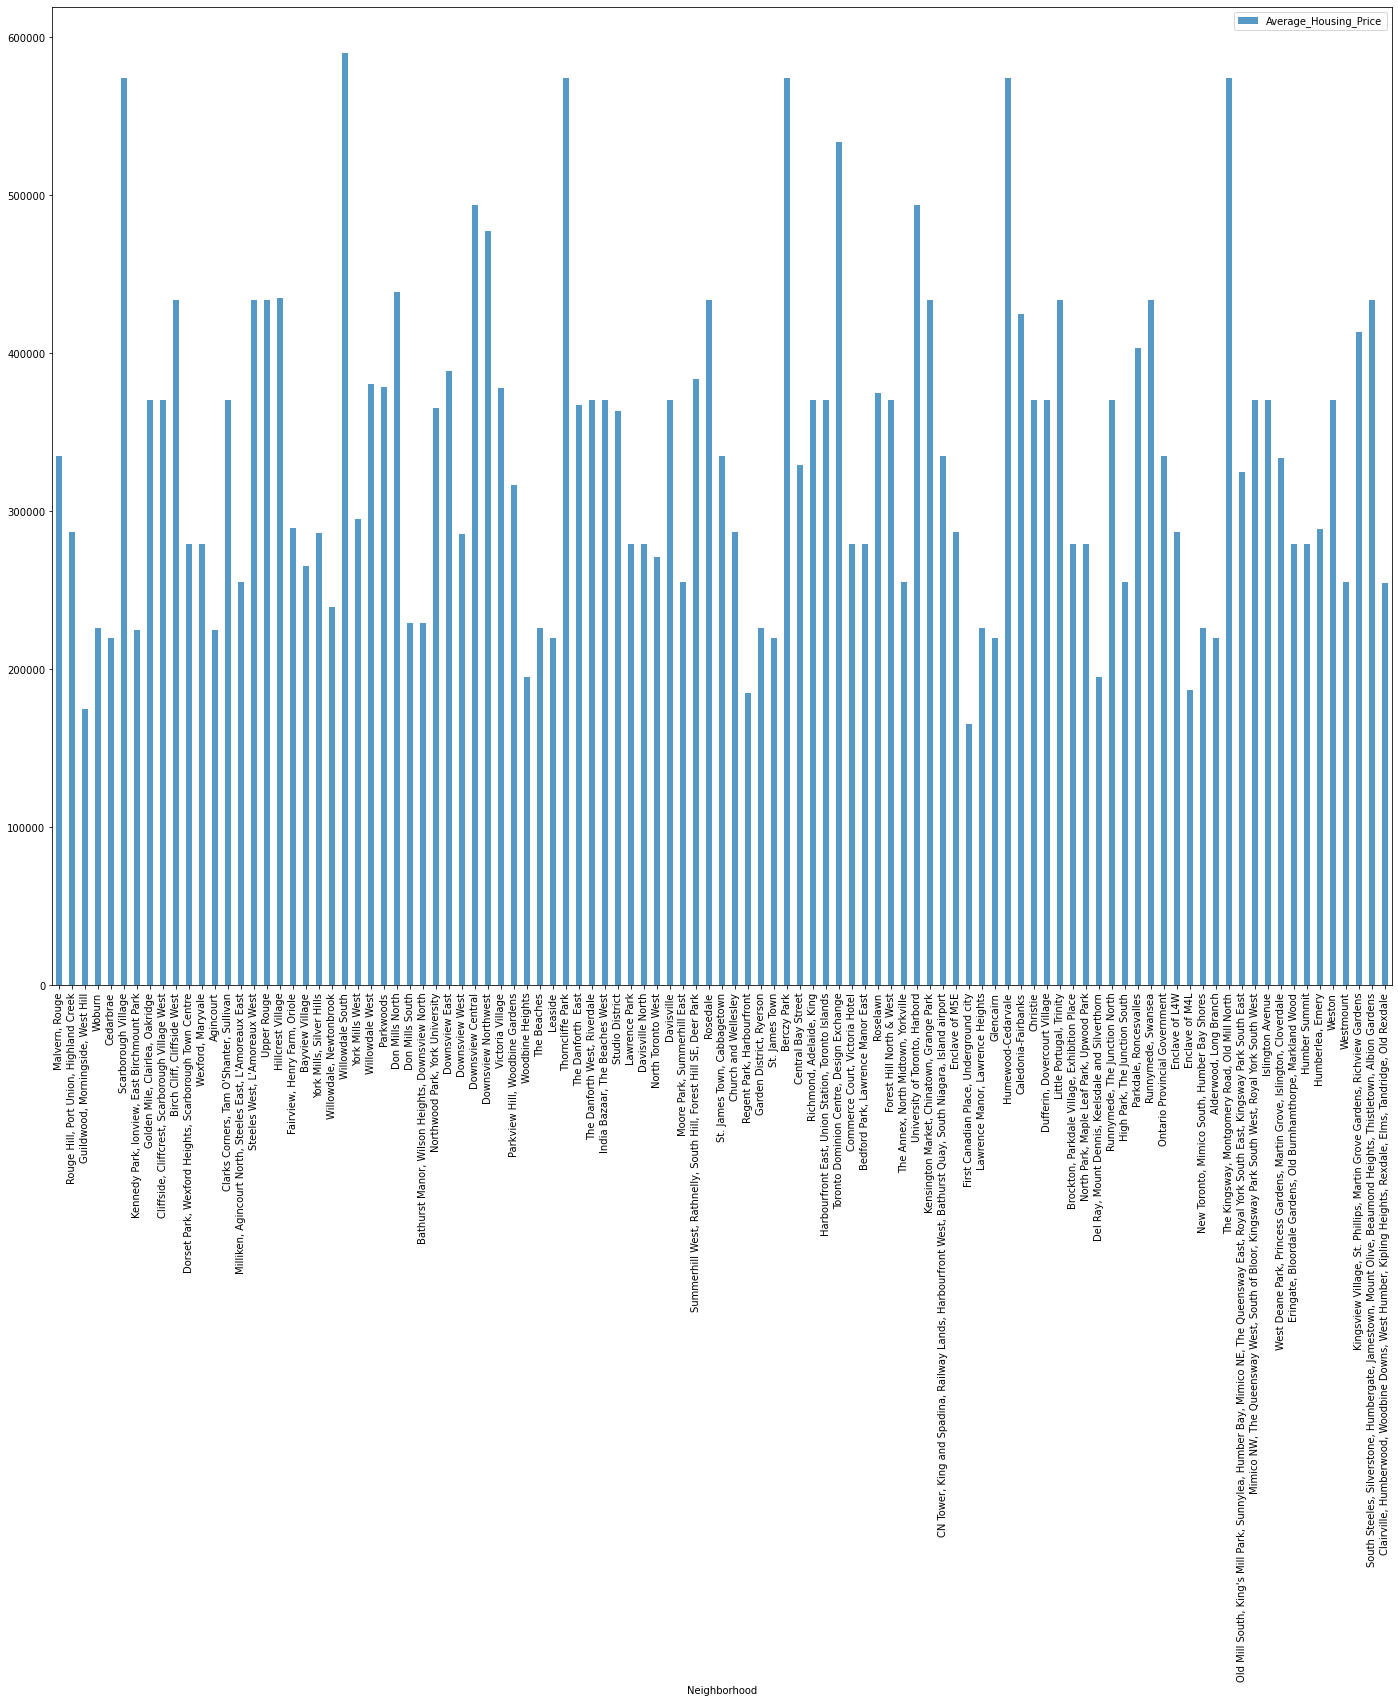

In [37]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

### School Ratings by Clusters

In [38]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster3":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [39]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

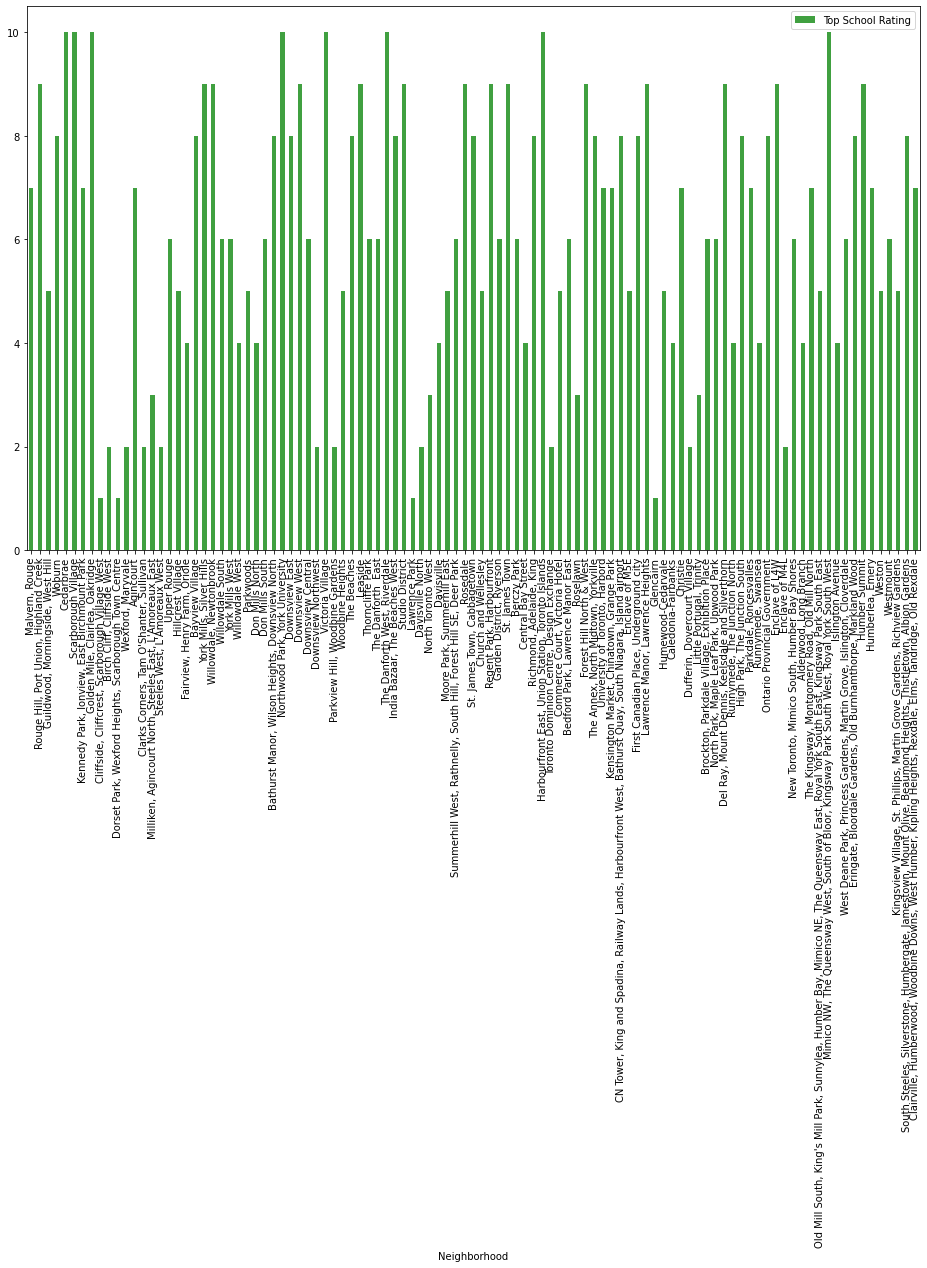

In [40]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

## Conclusion

### In the project, I used k-means clustering algorithm to separate the neighborhoods into 10 clusters for all 103 different locations from the given wikipedia link, which have very-similar neighborhoods around them. Using the charts above results I have presented the average house prices and school ratings in a given neighborhood.
### It was really great working on such a unique project. It helped me learn a lot in terms of how data science helps us in day to day. I have worked hard on this and I won't lie It took a lot of time but at the same time This course was definitely worth it. I hope you like my work.
### Thank you